Import Libraries


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

Load data

In [0]:
df = spark.read.option("header", True).option("inferSchema", True).csv("dbfs:/FileStore/tables/ecommerce_sales_400kb.csv")
df.show(5)

+-------+----------+-----------+------+----------+
|OrderID|   Product|   Category|Amount|      Date|
+-------+----------+-----------+------+----------+
|      1|Smartphone|Electronics|   699|2025-01-01|
|      2|    Laptop|Electronics|   999|2025-01-01|
|      3|      Book|      Books|    15|2025-01-02|
|      4|Headphones|Electronics|   199|2025-01-03|
|      5|     Chair|  Furniture|    85|2025-01-04|
+-------+----------+-----------+------+----------+
only showing top 5 rows



In [0]:
df = df.withColumn("Year", year(col("Date"))) \
       .withColumn("Month", month(col("Date"))) \
       .withColumn("Day", dayofmonth(col("Date")))

In [0]:
df = df.drop("OrderID")

In [0]:
product_indexer = StringIndexer(inputCol="Product", outputCol="ProductIndex")
category_indexer = StringIndexer(inputCol="Category", outputCol="CategoryIndex")

In [0]:
assembler = VectorAssembler(
    inputCols=["ProductIndex", "CategoryIndex", "Year", "Month", "Day"],
    outputCol="features"
)

In [0]:
df.select("Date").distinct().show(100, truncate=False)
df.filter(col("Date").isNull()).count()

+----------+
|Date      |
+----------+
|2025-01-09|
|NULL      |
|2025-01-10|
|2025-01-08|
|2025-01-12|
|2025-01-01|
|2025-01-05|
|2025-01-02|
|2025-01-07|
|2025-01-06|
|2025-01-11|
|2025-01-04|
|2025-01-03|
+----------+



1

In [0]:
df = df.na.drop()

In [0]:
df = df.filter(col("Product").isNotNull() & col("Category").isNotNull())

In [0]:
from pyspark.ml.feature import StringIndexer

product_indexer = StringIndexer(inputCol="Product", outputCol="ProductIndex", handleInvalid="keep")
category_indexer = StringIndexer(inputCol="Category", outputCol="CategoryIndex", handleInvalid="keep")

In [0]:
# Clean nulls
df = df.filter(col("Product").isNotNull() & col("Category").isNotNull())

# Index with handleInvalid
product_indexer = StringIndexer(inputCol="Product", outputCol="ProductIndex", handleInvalid="keep")
category_indexer = StringIndexer(inputCol="Category", outputCol="CategoryIndex", handleInvalid="keep")

In [0]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

In [0]:
lr = LinearRegression(featuresCol="features", labelCol="Amount")

pipeline = Pipeline(stages=[product_indexer, category_indexer, assembler, lr])

In [0]:
model = pipeline.fit(train_df)

In [0]:
lr = LinearRegression(featuresCol="features", labelCol="Amount")

pipeline = Pipeline(stages=[product_indexer, category_indexer, assembler, lr])

In [0]:
model = pipeline.fit(train_df)

In [0]:
predictions = model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="Amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

r2 = evaluator.setMetricName("r2").evaluate(predictions)
print(f"R2: {r2}")

RMSE: 164.3032576692168
R2: 0.22171595223672225


In [0]:
new_data = spark.createDataFrame([
    ("Product A", "Category 1", "2025-04-01")
], ["Product", "Category", "Date"])

new_data = new_data.withColumn("Date", col("Date").cast("date")) \
                   .withColumn("Year", year(col("Date"))) \
                   .withColumn("Month", month(col("Date"))) \
                   .withColumn("Day", dayofmonth(col("Date"))) \
                   .drop("Date")

predicted = model.transform(new_data)
predicted.select("Product", "Category", "prediction").show()

+---------+----------+-----------------+
|  Product|  Category|       prediction|
+---------+----------+-----------------+
|Product A|Category 1|819643.0399002535|
+---------+----------+-----------------+



In [0]:
predictions = model.transform(test_df)
predictions.select("Date", "Amount", "prediction").show()

+----------+------+-------------------+
|      Date|Amount|         prediction|
+----------+------+-------------------+
|2025-01-12|  20.0|-168.64031917939428|
|2025-01-11|  90.0| 10.478376370971091|
|2025-01-08|  45.0|    283.57283182221|
|2025-01-06|   5.0|  139.0362037261948|
|2025-01-06| 500.0|  365.1436180009041|
+----------+------+-------------------+



In [0]:
display(predictions.select("Date", "Amount", "prediction"))

Date,Amount,prediction
2025-01-12,20.0,-168.64031917939428
2025-01-11,90.0,10.478376370971091
2025-01-08,45.0,283.57283182221
2025-01-06,5.0,139.0362037261948
2025-01-06,500.0,365.1436180009041


In [0]:
import matplotlib.pyplot as plt

# Sort by date
pdf = pdf.sort_values(by="Date")

plt.figure(figsize=(12, 6))
plt.plot(pdf["Date"], pdf["Amount"], label="Actual Sales")
plt.plot(pdf["Date"], pdf["prediction"], label="Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.title("Actual vs Predicted Sales")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-3440323988010545>, line 4
      1 import matplotlib.pyplot as plt
      3 # Sort by date
----> 4 pdf = pdf.sort_values(by="Date")
      6 plt.figure(figsize=(12, 6))
      7 plt.plot(pdf["Date"], pdf["Amount"], label="Actual Sales")

NameError: name 'pdf' is not defined

In [0]:
# Convert predictions to Pandas DataFrame
pdf = predictions.select("Date", "Amount", "prediction").toPandas()

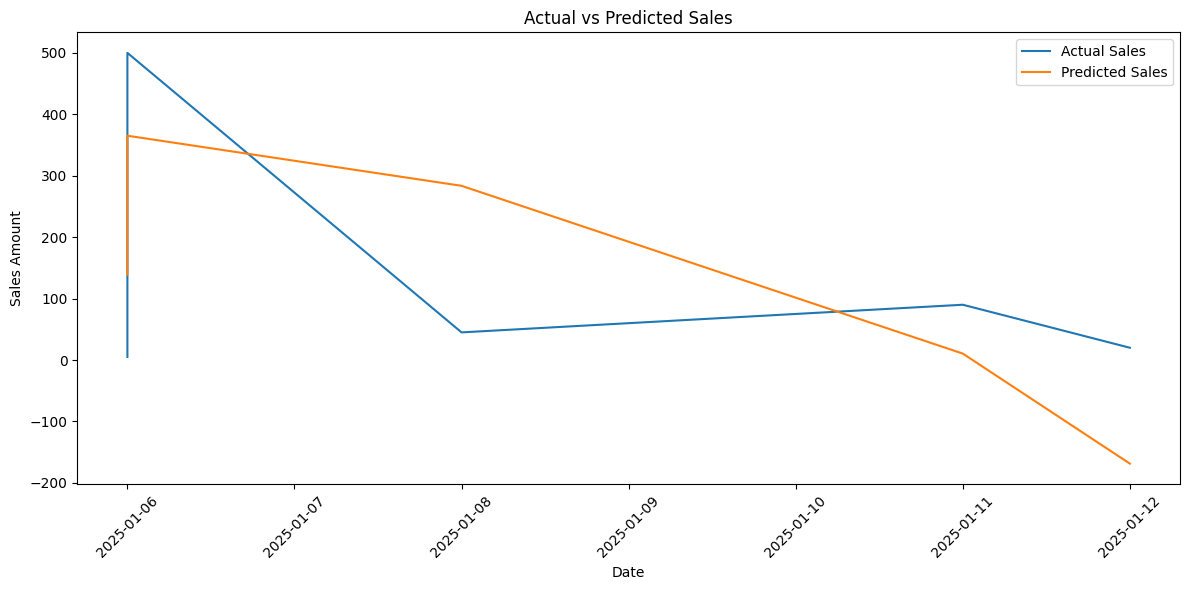

In [0]:
import matplotlib.pyplot as plt

pdf = pdf.sort_values(by="Date")  # Optional: ensure it's sorted

plt.figure(figsize=(12, 6))
plt.plot(pdf["Date"], pdf["Amount"], label="Actual Sales")
plt.plot(pdf["Date"], pdf["prediction"], label="Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.title("Actual vs Predicted Sales")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [0]:
%pip install seaborn

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


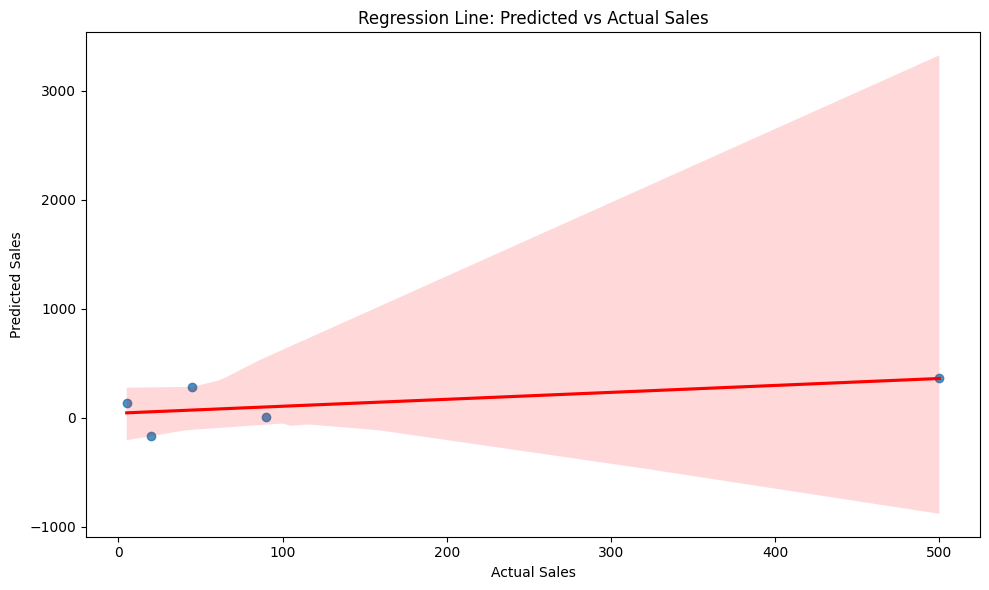

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=pdf, x="Amount", y="prediction", line_kws={"color": "red"})

plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Regression Line: Predicted vs Actual Sales")
plt.tight_layout()
plt.show()